## FM

In [23]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt

In [2]:
# 자료형 선언
tf.keras.backend.set_floatx('float32')

In [3]:
# Import data

# Training Data
df_train=pd.read_csv('./ua.base',sep='\t',header=None,engine='python')

# Test Data
df_test=pd.read_csv('./ua.test',sep='\t',header=None,engine='python')

In [4]:
num_user=943
num_item=1682

In [5]:
df_train.columns=['user_id','item_id','rating','timestamp']

In [6]:
df_train_user=pd.get_dummies(df_train['user_id'])
df_train_item=pd.get_dummies(df_train['item_id'])
df_train=df_train.join(df_train_user.add_prefix('user'))
df_train=df_train.join(df_train_item.add_prefix('item'))

In [7]:
df_test.columns=['user_id','item_id','rating','timestamp']
df_test_user=pd.get_dummies(df_test['user_id'])
df_test_item=pd.get_dummies(df_test['item_id'])
df_test=df_test.join(df_test_user.add_prefix('user'))
df_test=df_test.join(df_test_item.add_prefix('item'))

In [8]:
def rating_matrix(df):
    R=np.zeros((num_user,num_item))
    for index in range(len(df)):
        u=df['user_id'][index]-1
        i=df['item_id'][index]-1
        R[u,i]=df['rating'][index]
    return R

In [9]:
TR=rating_matrix(df_train)

In [10]:
# feature matrix
def feature_matrix(df):
    R=np.zeros((len(df),num_user+num_item*2+1))
    for i in range(len(df)):
        for j in range(num_user):
            R[i,j]=df['user{}'.format(j+1)][i]
        for j in range(num_user,num_user+num_item):
            try:
                R[i,j]=df['item{}'.format(j-num_user+1)][i]
            except:
                R[i,j]=0
        R[i,num_user+num_item:num_user+2*num_item]=TR[df['user_id'][i]-1,:]
        R[i,num_user+num_item*2]=df['rating'][i]
    return R

In [11]:
# preprocessing
R_train=feature_matrix(df_train)

In [12]:
TR=rating_matrix(df_test)

In [13]:
# preprocessing
R_test=feature_matrix(df_test)

In [14]:
# split training set and test set
X_train=R_train[:,:-1]
X_test=R_train[:,-1]
Y_train=R_test[:,:-1]
Y_test=R_test[:,-1]

In [15]:
# scaling
scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
Y_train=scaler.fit_transform(Y_train)

In [16]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

n, p = X_train.shape

# number of latent factors
k = 10

# design matrix
X = tf.placeholder('float', shape=[None, p])
# target vector
y = tf.placeholder('float', shape=[None, 1])

# bias and weights
w0 = tf.Variable(tf.zeros([1]))
W = tf.Variable(tf.zeros([p]))

# interaction factors, randomly initialized 
V = tf.Variable(tf.random_normal([k, p], stddev=0.01))

# estimate of y, initialized to 0.
y_hat = tf.Variable(tf.zeros([n, 1]))

Instructions for updating:
non-resource variables are not supported in the long term


In [17]:
# Calculate output with FM equation
linear_terms = tf.add(w0, tf.reduce_sum(tf.multiply(W, X), 1, keep_dims=True))
pair_interactions = (tf.multiply(0.5,
                    tf.reduce_sum(
                        tf.subtract(
                            tf.pow( tf.matmul(X, tf.transpose(V)), 2),
                            tf.matmul(tf.pow(X, 2), tf.transpose(tf.pow(V, 2)))),
                        1, keep_dims=True)))
y_hat = tf.add(linear_terms, pair_interactions)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [18]:
# L2 regularized sum of squares loss function over W and V
lambda_w = tf.constant(0.001, name='lambda_w')
lambda_v = tf.constant(0.001, name='lambda_v')

l2_norm = (tf.reduce_sum(
            tf.add(
                tf.multiply(lambda_w, tf.pow(W, 2)),
                tf.multiply(lambda_v, tf.pow(V, 2)))))

error = tf.reduce_mean(tf.square(tf.subtract(y, y_hat)))
loss = tf.add(error, l2_norm)

In [19]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(loss)

In [20]:
# mini match sgd
def batcher(X_, y_=None, batch_size=-1):
    n_samples = X_.shape[0]

    if batch_size == -1:
        batch_size = n_samples
    if batch_size < 1:
        raise ValueError('Parameter batch_size={} is unsupported'.format(batch_size))
 
    for i in range(0, n_samples, batch_size):
        upper_bound = min(i + batch_size, n_samples)
        ret_x = X_[i:upper_bound]
        ret_y = None
        if y_ is not None:
            ret_y = y_[i:i + batch_size]
            yield (ret_x, ret_y)

In [21]:
# training

epochs = 10
batch_size = 1000

# Launch the graph
init = tf.global_variables_initializer()
sess = tf.Session()

sess.run(init)
rmse=[]
for epoch in range(100):
    perm = np.random.permutation(X_train.shape[0])
    # iterate over batches
    for bX, bY in batcher(X_train[perm], X_test[perm], batch_size):
        sess.run(optimizer, feed_dict={X: bX.reshape(-1, p), y: bY.reshape(-1, 1)})
        
    errors = []
    for bX, bY in batcher(Y_train, Y_test):
        errors.append(sess.run(error, feed_dict={X: bX.reshape(-1, p), y: bY.reshape(-1, 1)}))

    RMSE = np.sqrt(np.array(errors).mean())
    rmse.append(RMSE)

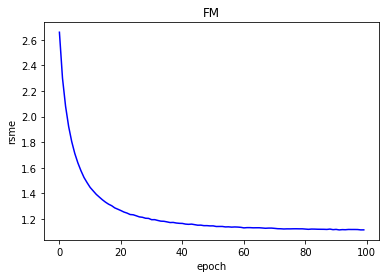

In [24]:
# plot

epoch=[i for i in range(100)]
plt.plot(epoch,rmse,'b') # rmse plot for FM
plt.xlabel('epoch')
plt.ylabel('rsme')
plt.title('FM')
plt.show()